# Tutorial 1: Getting Started

## Overview
Welcome to FastEstimator! In this tutorial we are going to cover:
* [The three main APIs of FastEstimator: `Pipeline`, `Network`, `Estimator`](#t01ThreeMain)
* [An image classification example](#t01ImageClassification)
    * [Pipeline](#t01Pipeline)
    * [Network](#t01Network)
    * [Estimator](#t01Estimator)
    * [Training](#t01Training)
    * [Inferencing](#t01Inferencing)
* [Related Apphub Examples](#t01Apphub)

<a id='t01ThreeMain'></a>

## Three main APIs
All deep learning training workﬂows involve the following three essential components, each mapping to a critical API in FastEstimator.

* **Data pipeline**: extracts data from disk/RAM, performs transformations. ->  `fe.Pipeline`


* **Network**: performs trainable and differentiable operations. ->  `fe.Network`


* **Training loop**: combines the data pipeline and network in an iterative process. ->  `fe.Estimator`

<BR>
<BR>
Any deep learning task can be constructed by following the 3 main steps:
<BR>
<p align="center">
<img src="https://github.com/fastestimator-util/fastestimator-misc/blob/master/resource/pictures/tutorial/t01_api.png?raw=true" alt="drawing" width="700"/>
</p>

<a id='t01ImageClassification'></a>

## Image Classification Example

<a id='t01Pipeline'></a>

### Step 1 - Pipeline
We use FastEstimator dataset API to load the MNIST dataset. Please check out [Tutorial 2](./t02_dataset.ipynb) for more details about the dataset API. In this case our data preprocessing involves: 
1. Expand image dimension from (28,28) to (28, 28, 1) for convenience during convolution operations.
2. Rescale pixel values from [0, 255] to [0, 1].

Please check out [Tutorial 3](./t03_operator.ipynb) for details about `Operator` and [Tutorial 4](./t04_pipeline.ipynb) for `Pipeline`.

In [1]:
import fastestimator as fe
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

train_data, eval_data = mnist.load_data()

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")])

<a id='t01Network'></a>

### Step 2 - Network

The model definition can be either from `tf.keras.Model` or `torch.nn.Module`, for more info about network definitions, check out [Tutorial 5](./t05_model.ipynb). The differentiable operations during training are listed as follows:

1. Feed the preprocessed images to the network and get prediction scores.
2. Calculate `CrossEntropy` (loss) between prediction scores and ground truth.
3. Update the model by minimizing `CrossEntropy`.

For more info about `Network` and its operators, check out [Tutorial 6](./t06_network.ipynb).

In [2]:
from fastestimator.architecture.tensorflow import LeNet
# from fastestimator.architecture.pytorch import LeNet  # One can also use a pytorch model

from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce") 
    ])

<a id='t01Estimator'></a>

### Step 3 - Estimator
We define the `Estimator` to connect the `Network` to the `Pipeline`, and compute accuracy as a validation metric. Please see [Tutorial 7](./t07_estimator.ipynb) for more about `Estimator` and `Traces`.

In [3]:
from fastestimator.trace.metric import Accuracy
from fastestimator.trace.io import BestModelSaver
import tempfile

traces = [Accuracy(true_key="y", pred_key="y_pred"),
          BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="accuracy", save_best_mode="max")]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=2,
                         traces=traces)

<a id='t01Training'></a>

### Start Training

In [4]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.308363;
FastEstimator-Train: step: 100; ce: 0.32775605; steps/sec: 76.05;
FastEstimator-Train: step: 200; ce: 0.09257892; steps/sec: 73.5;
FastEstimator-Train: step: 300; ce: 0.34083164; steps/sec: 76.4;
FastEstimator-Train: step: 400; ce: 0.1040692; steps/sec: 74.74;
FastEstimator-Train: step: 500; ce: 0.021515703; steps/sec: 77.2;
FastEstimator-Train: step: 600; ce: 0.06389343; steps/sec: 76.94;
FastEstimator-Train: step: 700; ce: 0.081933156; steps/s

<a id='t01Inferencing'></a>

### Inferencing
After training, we can do inferencing on new data with `Pipeline.transform` and `Netowork.transform`. Please checkout [Tutorial 8](./t08_mode.ipynb) for more details. \

Ground truth class is 7
Predicted class is 7


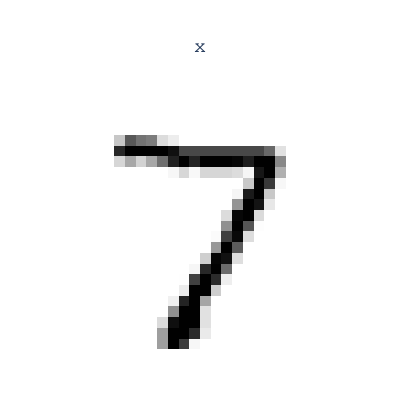

In [5]:
import numpy as np

data = eval_data[0]
data = pipeline.transform(data, mode="eval")
data = network.transform(data, mode="eval")

print("Ground truth class is {}".format(data["y"][0]))
print("Predicted class is {}".format(np.argmax(data["y_pred"])))
img = fe.util.BatchDisplay(title="x", image=data["x"])
img.show()

<a id='t01Apphub'></a>

## Apphub Examples
You can find some practical examples of the concepts described here in the following FastEstimator Apphubs:

* [MNIST](../../apphub/image_classification/mnist/mnist.ipynb)
* [DNN](../../apphub/tabular/dnn/dnn.ipynb)